In [1]:
import os
import shutil
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


def extract_features(file_path, sample_rate=22050):
    try:
        audio, sr = librosa.load(file_path, sr=sample_rate)
        # Extract features
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        return np.hstack((mfccs, chroma, mel))
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

In [2]:

def prepare_data(data_path, actor_to_train):
    X_train, y_train, X_test, y_test = [], [], [], []
    for actor_folder in os.listdir(data_path):
        actor_path = os.path.join(data_path, actor_folder)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(actor_path, file)
                    emotion = int(file.split('-')[2])  
                    feature = extract_features(file_path)
                    if feature is not None:
                        if actor_folder == actor_to_train:
                            X_train.append(feature)
                            y_train.append(emotion)
                        else:
                            X_test.append(feature)
                            y_test.append(emotion)
    return (
        np.array(X_train), 
        np.array(y_train), 
        np.array(X_test), 
        np.array(y_test)
    )

In [3]:

def segregate_files(data_path, model, encoder, output_dir="Predictions"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for actor_folder in os.listdir(data_path):
        actor_path = os.path.join(data_path, actor_folder)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(actor_path, file)
                    feature = extract_features(file_path)
                    if feature is not None:
                        predicted_emotion = model.predict([feature])[0]
                        emotion_label = str(encoder.inverse_transform([predicted_emotion])[0]) 
                        emotion_folder = os.path.join(output_dir, emotion_label)
                        if not os.path.exists(emotion_folder):
                            os.makedirs(emotion_folder)
                        shutil.copy(file_path, emotion_folder)

In [4]:
data_path = "C:\\Users\\grand\\Downloads\\archive (1)"  # Replace with the path to the RAVDESS dataset
actor_to_train = "Actor_01"  # Replace with the actor you want to train on

In [5]:
X_train, y_train, X_test, y_test = prepare_data(data_path, actor_to_train)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_encoded)

RandomForestClassifier(random_state=42)

In [6]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=encoder.classes_.astype(str)))
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        92
           2       0.40      0.64      0.49       184
           3       0.21      0.20      0.20       184
           4       0.20      0.02      0.03       184
           5       0.38      0.59      0.46       184
           6       0.22      0.13      0.16       184
           7       0.21      0.48      0.29       184
           8       0.38      0.14      0.21       184

    accuracy                           0.29      1380
   macro avg       0.25      0.27      0.23      1380
weighted avg       0.27      0.29      0.25      1380

Model Accuracy: 29.28%


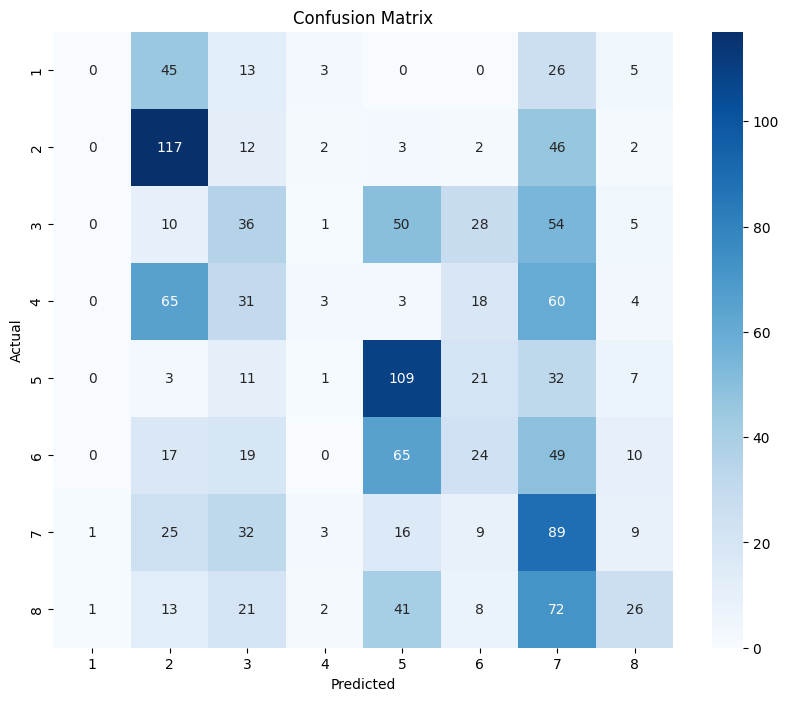

In [7]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [8]:
output_dir = "Predictions"
segregate_files(data_path, clf, encoder, output_dir)
print(f"Files segregated into {output_dir}/ based on predictions.")

Files segregated into Predictions/ based on predictions.
